In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw4.ipynb")

## Homework #4

*Please edit the cell below to add your full name (first and last) and the full names of any group members that you collaborated with on this assignment.* 

Name: Runze Li    
Group Members: None   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
np.random.seed(5)

%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [3]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

<!-- BEGIN QUESTION -->

**Question 1.** **(25 points)** In the Laffer data (*Data/Laffer.csv*, first introduced in the accompanying prediction tutorial), there is one country with a high tax revenue that is an outlier. 

In the tutorial, PSIS and WAIC were used to measure the importance of this outlier in the models that were fit. 

First, re-create and run the models provided as part of **the prediction tutorial**.

In [4]:
# Write code here
from matplotlib import animation, pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from quap import quap
from scipy import stats

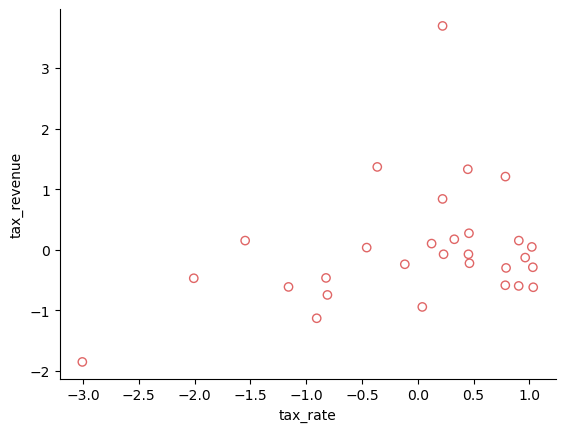

In [5]:
df = pd.read_csv("Data/Laffer.csv", header=0)
# standardizing tax rate and tax revenue
tax_rate_std = standardize(df.tax_rate)
tax_revenue_std = standardize(df.tax_revenue)

_ = plt.scatter(tax_rate_std, tax_revenue_std, facecolors='none', edgecolors="#e06666")
_ = plt.xlabel("tax_rate")
_ = plt.ylabel("tax_revenue")
_ = sns.despine()

In [6]:
# first-order linear model
with pm.Model() as m_ex4_lin:
    
    # prior on intercept for expected tax revenue: mean = 0, std = 0.2
    a = pm.Normal("a", 0, 0.2)
    
    # prior on coefficient for tax rate: mean=0, std=0.5
    b = pm.Normal("b", 0, 0.5)
    
    # expected tax revenue (using linear model)
    mu = pm.Deterministic("mu", a + b * tax_rate_std)
    
    # standard deviation for tax revenue
    sigma = pm.Exponential("sigma", 1)
    
    # data distribution for tax revenue
    R = pm.Normal("tax_revenue", mu, sigma, observed=tax_revenue_std)
    
    # using Hamiltonian Monte Carlo MCMC
    idata_ex4_lin = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
# quadratic model
with pm.Model() as m_ex4_quad:
    # prior on intercept for expected tax revenue: mean = 0, std = 0.2
    a = pm.Normal("a", 0, 0.2)
    
    # prior on coefficient for tax rate: mean=0, std=0.5
    b = pm.Normal("b", 0, 0.5)
    
    # prior on coefficient for tax rate^2: mean=0, std=0.5
    b2 = pm.Normal("b2", 0, 0.5)
    
    # expected tax revenue (using polynomial model)
    mu = pm.Deterministic("mu", a + b * tax_rate_std + b2 * tax_rate_std**2)
    
    # standard deviation for tax revenue
    sigma = pm.Exponential("sigma", 1)
    
    # data distribution for tax revenue
    R = pm.Normal("tax_revenue", mu, sigma, observed=tax_revenue_std)
    
    # using Hamiltonian Monte Carlo MCMC
    idata_ex4_quad = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, b2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Create a new **cubic** (3rd-degree polynomial) version of the model.

In [8]:
# Write code here
with pm.Model() as m_ex4_cubic:
    a = pm.Normal("a", 0, 0.2)
    b = pm.Normal("b", 0, 0.5)
    b2 = pm.Normal("b2", 0, 0.5)
    b3 = pm.Normal("b3", 0, 0.5)
    mu = pm.Deterministic("mu", a + b * tax_rate_std + b2 * tax_rate_std**2 + b3 * tax_rate_std**3)
    sigma = pm.Exponential("sigma", 1)
    R = pm.Normal("tax_revenue", mu, sigma, observed=tax_revenue_std)
    idata_ex4_cubic = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, b2, b3, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Create a new (first-order) **linear** version of the model using robust regression with a Student’s t distribution for the data distribution. Use $\nu=2$ for your Student's t distribution. 

In [9]:
# Write code here
with pm.Model() as m_ex4_lin_t:
    a = pm.Normal("a", 0, 0.2)
    b = pm.Normal("b", 0, 0.5)
    mu = pm.Deterministic("mu", a + b * tax_rate_std)
    sigma = pm.Exponential("sigma", 1)
    # R = pm.Normal("tax_revenue", mu, sigma, observed=tax_revenue_std)
    R = pm.StudentT("tax_revenue", nu=2, mu=mu, sigma=sigma, observed=tax_revenue_std)
    
    # using Hamiltonian Monte Carlo MCMC
    idata_ex4_lin_t = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Of the 4 models, which one has the best predictive performance according to PSIS? 

_Type your answer here, replacing this text._

__Answer:__   
According to the code and the obtained tables and images below, we can see that a first-order linear version of the model using robust regression with a Student’s t distribution has the best predictive performance.

In [10]:
# Write code here
model_dict = {
    "m_ex4_lin": idata_ex4_lin,
    "m_ex4_quad": idata_ex4_quad,
    "m_ex4_cubic": idata_ex4_cubic,
    "m_ex4_lin_t": idata_ex4_lin_t
}

In [11]:
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
compare_df_psis

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_ex4_lin_t,0,73.858197,3.268685,0.000000,7.602459e-01,12.359460,0.000000,False,deviance
m_ex4_quad,1,86.256166,5.520825,12.397968,2.397541e-01,20.073858,12.406429,True,deviance
m_ex4_lin,2,86.393456,4.599286,12.535259,2.333154e-16,18.119205,10.627975,True,deviance
m_ex4_cubic,3,86.860951,5.654654,13.002754,2.220446e-16,18.478783,10.848989,True,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


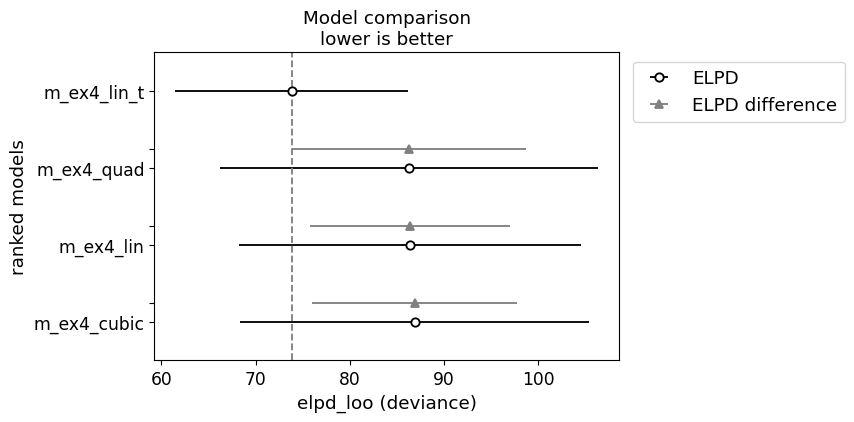

In [12]:
_ = az.plot_compare(compare_df_psis)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Based on these results, what impact does the outlier point appear to be having on the curved relationship between tax rate and tax revenue?

_Type your answer here, replacing this text._

__Answer:__   

Here are some specific effects that outliers may have on this relationship:   

Firstly, an outlier with high taxes may pull the curve upward, making it appear that tax revenue is still increasing at higher tax rates. This may mask the fact that most countries have reduced tax revenue at high tax rates, leading to a misjudgment of tax rates.

What's more, the presence of an outlier may cause the difference between the observed and predicted values to be larger near the outlier, indicating that the model fits poorly in this area.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2**. **(15 points)** Reconsider the urban fox analysis (*Data/foxes.csv*) from the previous homework assignment (HW 3). 

On the basis of PSIS and WAIC scores, which combination of variables best predicts body weight ($W$, `weight`)? 

*Note: For this exercise, you will end up creating 7 models.*

_Type your answer here, replacing this text._

In [13]:
# Write code here
d = pd.read_csv("Data/foxes.csv", header=0)
A = standardize(d.area)
F = standardize(d.avgfood)
G = standardize(d.groupsize)
W = standardize(d.weight)

In [14]:
# A -> W
with pm.Model() as m_AW:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    mu = pm.Deterministic("mu", a + bA*A)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu, sigma, observed=W)
    idata_AW = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bA, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [15]:
# F -> W
with pm.Model() as m_FW:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    mu = pm.Deterministic("mu", a + bF*F)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu, sigma, observed=W)
    idata_FW = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bF, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
# G -> W
with pm.Model() as m_GW:
    a = pm.Normal("a", 0, 0.2)
    bG = pm.Normal("bG", 0, 0.5)
    mu = pm.Deterministic("mu", a + bG*G)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu, sigma, observed=W)
    idata_GW = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bG, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
# A,F -> W
with pm.Model() as m_AFW:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bF = pm.Normal("bF", 0, 0.5)
    mu = pm.Deterministic("mu", a + bA*A + bF*F)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu, sigma, observed=W)
    idata_AFW = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bA, bF, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [18]:
# A,G -> W
with pm.Model() as m_AGW:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bG = pm.Normal("bG", 0, 0.5)
    mu = pm.Deterministic("mu", a + bA*A + bG*G)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu, sigma, observed=W)
    idata_AGW = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bA, bG, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
# F,G -> W
with pm.Model() as m_FGW:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bG = pm.Normal("bG", 0, 0.5)
    mu = pm.Deterministic("mu", a + bF*F + bG*G)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu, sigma, observed=W)
    idata_FGW = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bF, bG, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [20]:
# A,F,G -> W
with pm.Model() as m_AFGW:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bF = pm.Normal("bF", 0, 0.5)
    bG = pm.Normal("bG", 0, 0.5)
    mu = pm.Deterministic("mu", a + bA*A + bF*F + bG*G)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu, sigma, observed=W)
    idata_AFGW = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bA, bF, bG, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [21]:
model_dict = {
    "m_AW": idata_AW,
    "m_FW": idata_FW,
    "m_GW": idata_GW,
    "m_AFW": idata_AFW,
    "m_AGW": idata_AGW,
    "m_FGW": idata_FGW,
    "m_AFGW": idata_AFGW 
}

In [22]:
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
compare_df_psis

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_AFGW,0,323.050622,4.556598,0.000000,0.000000,15.450011,0.000000,False,deviance
m_FGW,1,323.522877,3.416537,0.472255,0.507556,15.260706,3.348244,False,deviance
m_AGW,2,323.528158,3.438211,0.477537,0.492444,15.051244,2.671600,False,deviance
m_GW,3,330.380742,2.405643,7.330121,0.000000,14.028121,5.568209,False,deviance
m_FW,4,333.330938,2.289064,10.280317,0.000000,13.279070,6.685836,False,deviance
m_AW,5,333.794071,2.603583,10.743449,0.000000,13.237525,6.743830,False,deviance
m_AFW,6,334.150065,3.267558,11.099444,0.000000,13.497847,6.490319,False,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


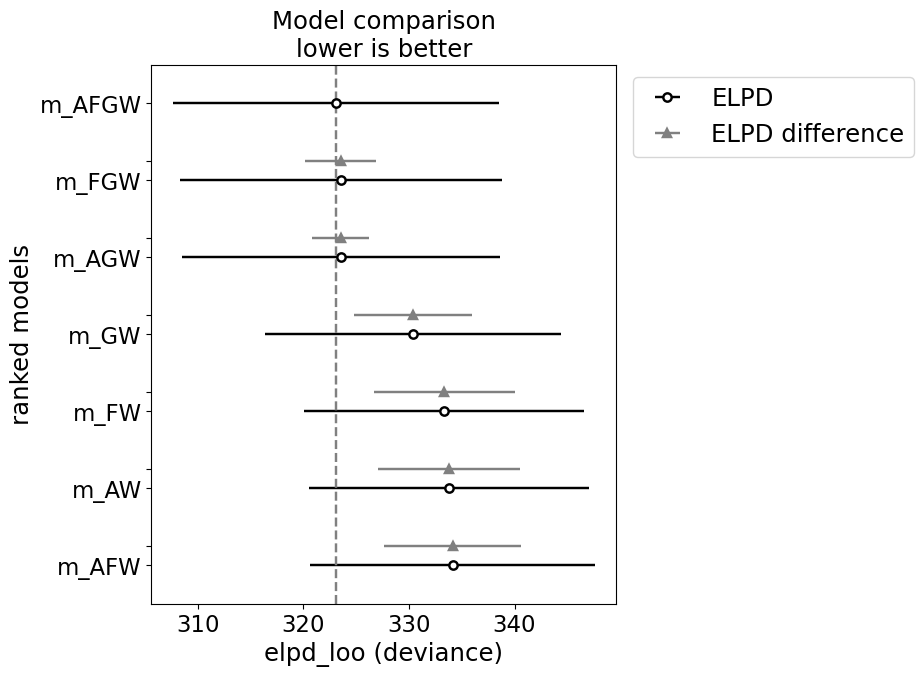

In [23]:
_ = az.plot_compare(compare_df_psis)

In [24]:
compare_df_waic = az.compare(
    compare_dict=model_dict,
    ic="waic",
    scale="deviance"
)
compare_df_waic

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureW

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m_AFGW,0,322.998709,4.530641,0.000000,0.000000e+00,15.442249,0.000000,True,deviance
m_FGW,1,323.490613,3.400405,0.491904,5.074325e-01,15.254433,3.348764,False,deviance
m_AGW,2,323.493862,3.421063,0.495153,4.925675e-01,15.043975,2.670775,True,deviance
m_GW,3,330.365015,2.397779,7.366306,0.000000e+00,14.025483,5.566241,False,deviance
m_FW,4,333.316473,2.281831,10.317764,9.629450e-16,13.277132,6.682825,False,deviance
m_AW,5,333.773782,2.593439,10.775073,0.000000e+00,13.234467,6.741424,False,deviance
m_AFW,6,334.113111,3.249081,11.114403,0.000000e+00,13.491377,6.487992,False,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


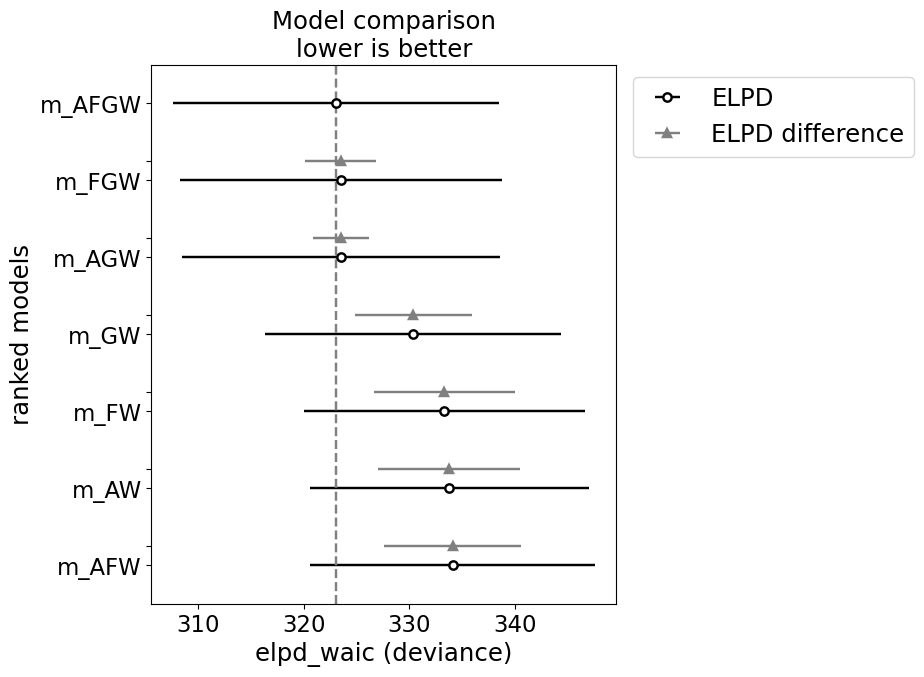

In [25]:
_ = az.plot_compare(compare_df_waic)

__Answer:__  

According to the ranking table and graph of PSIS and WAIC obtained above, we can see that the variables of area(A), average food(F) and group size(G) can best predict body weight(W).

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Answer the following question based on your analysis above: 

How would you interpret the estimates for the coefficients from the best scoring model in terms of their ability to predict weight?

_Type your answer here, replacing this text._

__Answer:__   

Generally speaking, we think of the coefficients as the beta values in the model. A positive coefficient indicates that as the corresponding predictor variable increases, the predicted weight also increases. Correspondingly, A negative coefficient suggests that an increase in the predictor variable leads to a decrease in the predicted weight. What's more, a larger coefficient means that the variable has a stronger influence on the predicted weight.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3. (10 points)** Using the data in  *Data/cherry_blossoms.csv*:

In this problem, you will build predictive models of the relationship between the timing of cherry blossoms (`doy`) and March temperature in the same year (`temp`). 

*Note:*
*   Only include observations that have recorded values for `doy` and `temp` (i.e., exclude `NaN` values). 
*   The [`pandas.DataFrame.dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method can be used to exclude `NaN` values. 


Construct at least two different models to predict `doy` with `temp`.

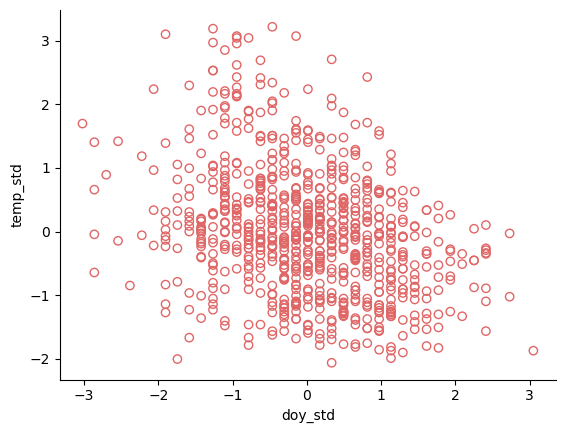

In [26]:
# Write code here
df = pd.read_csv("Data/cherry_blossoms.csv", header=0)
df_clean = df.dropna()
# standardizing tax rate and tax revenue
doy_std = standardize(df_clean.doy)
temp_std = standardize(df_clean.temp)

_ = plt.scatter(doy_std, temp_std, facecolors='none', edgecolors="#e06666")
_ = plt.xlabel("doy_std")
_ = plt.ylabel("temp_std")
_ = sns.despine()

In [27]:
# first-order linear model
with pm.Model() as m_ex4_lin:
    a = pm.Normal("a", 0, 0.2)
    b = pm.Normal("b", 0, 0.5)
    mu = pm.Deterministic("mu", a + b * doy_std)
    sigma = pm.Exponential("sigma", 1)
    temp = pm.Normal("temp", mu, sigma, observed=temp_std)
    
    idata_ex4_lin = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [28]:
# quadratic model
with pm.Model() as m_ex4_quad:
    a = pm.Normal("a", 0, 0.2)
    b = pm.Normal("b", 0, 0.5)
    b2 = pm.Normal("b2", 0, 0.5)
    mu = pm.Deterministic("mu", a + b * doy_std + b2 * doy_std**2)
    sigma = pm.Exponential("sigma", 1)
    temp = pm.Normal("temp", mu, sigma, observed=temp_std)

    idata_ex4_quad = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, b2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<!-- END QUESTION -->

 Compare the two models with PSIS or WAIC. 

<!-- BEGIN QUESTION -->



In [29]:
# Write code here
model_dict = {
    "m_ex4_lin": idata_ex4_lin,
    "m_ex4_quad": idata_ex4_quad
}

In [30]:
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
compare_df_psis

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_ex4_quad,0,2149.397401,3.816842,0.000000,0.5,41.870380,0.00000,False,deviance
m_ex4_lin,1,2149.397615,3.003751,0.000214,0.5,42.040048,2.39867,False,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


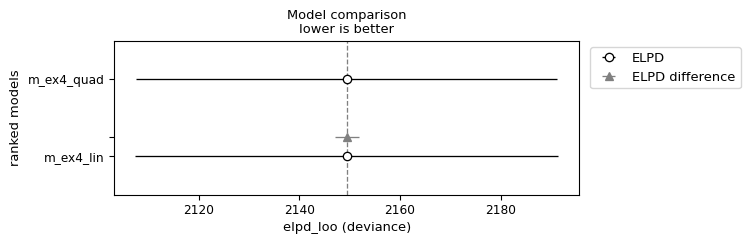

In [31]:
_ = az.plot_compare(compare_df_psis)

In [32]:
compare_df_waic = az.compare(
    compare_dict=model_dict,
    ic="waic",
    scale="deviance"
)
compare_df_waic

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m_ex4_quad,0,2149.376162,3.806222,0.000000,0.503036,41.869156,0.00000,False,deviance
m_ex4_lin,1,2149.383485,2.996686,0.007323,0.496964,42.039032,2.39872,False,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


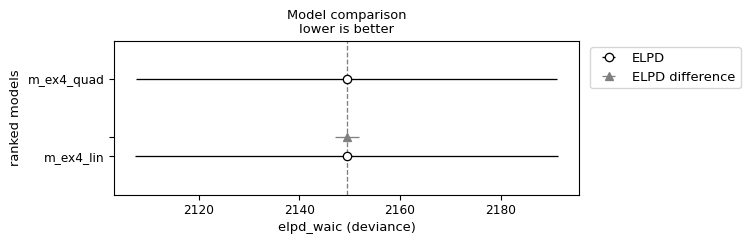

In [33]:
_ = az.plot_compare(compare_df_waic)

State which model is better and explain what evidence leads you to this conclusion.

_Type your answer here, replacing this text._

__Answer:__

In the two models we built, we can see from the above chart that the prediction effect of quadratic model is better than that of first-order linear model because _elpd_loo_ and _elpd_waic_ values of quadratic model are smaller.

In [34]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)